In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25

In [3]:
filenames = {
    "herwig": "../GAN-data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [4]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('./data/processed/np_bg_SR_2.npy')
np_sig_SR = np.load('./data/processed/np_sig_SR_2.npy')

np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)
#add sb label
np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)
np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

9

In [5]:
gen_model = tf.keras.models.load_model('./Results/epoch1000-generator.h5')

In [6]:
def generate_gan(generator, realdata):


    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)
   

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)

    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)

    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_bg_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [7]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [8]:
#add signal or background labels to "real" data
np_bg_SR_labeled  = np.copy(np_bg_SR)
np_bg_SR_labeled  = np.append(np_bg_SR_labeled ,np.zeros([len(np_bg_SR_labeled) ,1]),1)
np_sig_SR_labeled  = np.copy(np_sig_SR)
np_sig_SR_labeled  = np.append(np_sig_SR_labeled ,np.ones([len(np_sig_SR_labeled) ,1]),1)

In [9]:
np_bg_SR_labeled.shape

(242676, 11)

In [32]:
# split background in SR into testing and training. Testing is to inject signals
train_bg,test_bg,train_sb,test_sb =train_test_split(np_bg_SR_labeled[:,0:10],np_bg_SR_labeled[:,-1], test_size = 0.5, random_state=42)
sb = train_sb.reshape(len(train_sb),1)
training_dataset =  np.concatenate((train_bg,sb),axis=1)
test_dataset = np.concatenate((test_bg,sb),axis=1)
testing_sample = np.concatenate((np_sig_SR_labeled,test_data),axis=0)

In [33]:
testing_sample.shape

(271934, 11)

In [18]:
#inject signal into train dataset
sb_ratio = np.logspace(-3,-0.205,5)
#sb_ratio = np.linspace(0,0.62,10)
mixedsb = []
generated_data = []

for i in sb_ratio:
    sampled_signal = np.random.choice(np_sig_SR_labeled.shape[0], (int)(i * training_dataset.shape[0]))
    combined = np.concatenate((np_sig_SR_labeled[sampled_signal,:],training_dataset), axis =0) #inject signal (have sb label)
    gen = generate_gan(gen_model,combined)
    gen2 = generate_gan(gen_model,combined)
    gen_data = np.concatenate((gen,gen2),axis=0)
    generated_data_labeled  = np.copy(gen_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1) #create fake bg data with sb label
    mixedsb.append(sample_data(combined,100000))
    generated_data.append(generated_data_labeled)
    

In [21]:
mixed_df = pd.DataFrame(mixedsb[4], columns =  ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])

In [22]:
mixed_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1605.483154,1.000647,228.192993,1587.679077,0.203871,3.130290,143.259003,0.630974,0.528551,3469.777100,0.0
1,1775.284668,-0.512316,127.000000,1714.891113,-0.752384,3.178193,499.428986,0.655216,0.227997,3585.634033,1.0
2,1310.102661,-0.604168,319.746002,1062.291138,1.294275,3.266034,91.808998,0.231126,0.816170,3537.407227,0.0
3,1278.900269,-0.741175,80.557701,1233.597900,1.046434,2.770228,140.858994,0.654327,0.566766,3561.122559,0.0
4,1492.279053,-0.301728,476.826996,1431.781128,0.618392,3.220258,118.347000,0.252422,0.450230,3312.446045,1.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1236.254517,-0.657310,341.247009,1127.051147,1.170675,3.334448,95.198601,0.368925,0.784384,3451.262939,0.0
99996,1826.660278,-0.148092,124.406998,1752.740601,0.219854,3.150862,170.992996,0.221016,0.631358,3651.651367,0.0
99997,1344.523560,0.383960,294.324005,1343.813354,-1.087224,3.262980,259.289001,0.551863,0.489868,3492.773438,0.0
99998,1751.335571,-0.133025,156.908005,1620.635254,-0.545625,3.201935,229.742996,0.673359,0.221109,3462.104248,0.0


In [66]:
generated_df = pd.DataFrame(mixedsb[4], columns =  ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])

In [67]:
generated_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1605.483154,1.000647,228.192993,1587.679077,0.203871,3.130290,143.259003,0.630974,0.528551,3469.777100,0.0
1,1775.284668,-0.512316,127.000000,1714.891113,-0.752384,3.178193,499.428986,0.655216,0.227997,3585.634033,1.0
2,1310.102661,-0.604168,319.746002,1062.291138,1.294275,3.266034,91.808998,0.231126,0.816170,3537.407227,0.0
3,1278.900269,-0.741175,80.557701,1233.597900,1.046434,2.770228,140.858994,0.654327,0.566766,3561.122559,0.0
4,1492.279053,-0.301728,476.826996,1431.781128,0.618392,3.220258,118.347000,0.252422,0.450230,3312.446045,1.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1236.254517,-0.657310,341.247009,1127.051147,1.170675,3.334448,95.198601,0.368925,0.784384,3451.262939,0.0
99996,1826.660278,-0.148092,124.406998,1752.740601,0.219854,3.150862,170.992996,0.221016,0.631358,3651.651367,0.0
99997,1344.523560,0.383960,294.324005,1343.813354,-1.087224,3.262980,259.289001,0.551863,0.489868,3492.773438,0.0
99998,1751.335571,-0.133025,156.908005,1620.635254,-0.545625,3.201935,229.742996,0.673359,0.221109,3462.104248,0.0


In [72]:
generated_df = generated_df.drop(['sblabel'],axis=1)

In [75]:
generated_data = generated_df.to_numpy()
generated_data =  np.append(generated_data,np.zeros([len(generated_data),1]),1)

In [76]:
generated_df_fixed = pd.DataFrame(generated_data, columns =  ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])

In [78]:
generated_df_fixed

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1605.483154,1.000647,228.192993,1587.679077,0.203871,3.130290,143.259003,0.630974,0.528551,3469.777100,0.0
1,1775.284668,-0.512316,127.000000,1714.891113,-0.752384,3.178193,499.428986,0.655216,0.227997,3585.634033,0.0
2,1310.102661,-0.604168,319.746002,1062.291138,1.294275,3.266034,91.808998,0.231126,0.816170,3537.407227,0.0
3,1278.900269,-0.741175,80.557701,1233.597900,1.046434,2.770228,140.858994,0.654327,0.566766,3561.122559,0.0
4,1492.279053,-0.301728,476.826996,1431.781128,0.618392,3.220258,118.347000,0.252422,0.450230,3312.446045,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1236.254517,-0.657310,341.247009,1127.051147,1.170675,3.334448,95.198601,0.368925,0.784384,3451.262939,0.0
99996,1826.660278,-0.148092,124.406998,1752.740601,0.219854,3.150862,170.992996,0.221016,0.631358,3651.651367,0.0
99997,1344.523560,0.383960,294.324005,1343.813354,-1.087224,3.262980,259.289001,0.551863,0.489868,3492.773438,0.0
99998,1751.335571,-0.133025,156.908005,1620.635254,-0.545625,3.201935,229.742996,0.673359,0.221109,3462.104248,0.0


In [35]:
test_df = pd.DataFrame(testing_sample, columns =  ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])

In [36]:
test_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1914.942993,0.369530,105.035004,1583.804443,-0.185737,2.898982,461.574005,0.552809,0.121353,3662.211182,1.0
1,1684.598755,-0.523116,159.865997,1647.186768,0.110357,3.141156,514.883972,0.440781,0.299984,3586.710693,1.0
2,1789.997070,0.156652,93.665901,1569.509399,0.144243,3.235663,475.316986,0.136103,0.135523,3421.777344,1.0
3,1672.631348,-1.015185,116.327003,1568.322998,-0.350886,3.165926,561.236023,0.617014,0.294746,3536.982910,1.0
4,1431.694946,-0.700751,513.015991,1099.721313,0.945019,3.245961,108.752998,0.183145,0.456454,3481.573486,1.0
...,...,...,...,...,...,...,...,...,...,...,...
271929,1227.959229,1.449520,58.746700,1065.344727,-0.411850,2.799537,125.490997,0.600681,0.619995,3337.869141,0.0
271930,1447.491943,0.133693,382.397003,1304.911377,1.394691,3.029165,334.260010,0.637250,0.452088,3398.224365,0.0
271931,1283.751709,-0.036741,349.522003,1119.477783,1.684605,3.130704,56.165401,0.568723,0.568059,3403.787109,0.0
271932,1259.622437,-0.325118,221.408997,1240.384521,1.267860,3.103868,94.780098,0.469168,0.667305,3357.853516,0.0


In [81]:
classifier_real = mixedsb[4][:,[2,6,7,8]]
classifier_fake = generated_data[:,[2,6,7,8]]
sblabel_real = mixedsb[4][:,-1]
sblabel_fake = generated_data[:,-1]

unscaled_data = np.concatenate((classifier_real,classifier_fake),axis=0)
scaler = StandardScaler().fit(unscaled_data)
scaled_data = scaler.transform(unscaled_data)
sblabel = np.concatenate((sblabel_real,sblabel_fake),axis = 0)
sblabel = sblabel.reshape(len(sblabel),1)
rflabels = np.concatenate((np.ones([len(classifier_real),1]),np.zeros([len(classifier_fake),1])),axis=0)
scaled_data = np.concatenate((scaled_data,sblabel),axis=1)
scaled_data = np.concatenate((scaled_data,rflabels),axis=1)


scaled_sb = testing_sample[:,-1].reshape(len(testing_sample),1)
scaled_test = scaler.transform(testing_sample[:,[2,3,7,8]])
scaled_test_data = np.concatenate((scaled_test,scaled_sb),axis=1)



In [87]:
train_df = pd.DataFrame(scaled_data, columns = ['m1','m2','tau21j1','tau21j2','sb','rf'])

In [88]:
train_df

,m1,m2,tau21j1,tau21j2,sb,rf
0,-0.165926,-0.600478,0.894672,0.378011,0.0,1.0
1,-0.704658,1.414497,1.009812,-1.039171,1.0,1.0
2,0.321485,-0.891548,-1.004446,1.734206,0.0,1.0
3,-0.951908,-0.614055,1.005587,0.558203,0.0,1.0
4,1.157753,-0.741413,-0.903302,0.008707,1.0,1.0
...,...,...,...,...,...,...
199995,0.435952,-0.872372,-0.349955,1.584327,0.0,0.0
199996,-0.718462,-0.443577,-1.052465,0.862773,0.0,0.0
199997,0.186143,0.055943,0.518925,0.195613,0.0,0.0
199998,-0.545433,-0.111208,1.095982,-1.071654,0.0,0.0


In [82]:
test_df = pd.DataFrame(scaled_test_data, columns = ['m1','m2','tau21j1','tau21j2','sb'])

In [83]:
test_df

,m1,m2,tau21j1,tau21j2,sb
0,-0.821595,7.549176,0.523417,-1.542026,1.0
1,-0.529686,7.907751,-0.008669,-0.699738,1.0
2,-0.882122,7.468304,-1.455771,-1.475209,1.0
3,-0.761479,7.461592,0.828365,-0.724435,1.0
4,1.350417,4.810554,-1.232340,0.038058,1.0
...,...,...,...,...,...
271929,-1.068025,4.616074,0.750790,0.809193,0.0
271930,0.655026,5.971383,0.924478,0.017469,0.0
271931,0.480006,4.922323,0.599003,0.564303,0.0
271932,-0.202043,5.606333,0.126156,1.032268,0.0


In [84]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()


In [85]:
classifier = classifier_model()
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

Train on 160000 samples, validate on 40000 samples
Epoch 1/5
160000/160000 [==============================] - 6s 40us/sample - loss: 0.6935 - tp: 37366.0000 - fp: 37222.0000 - tn: 42771.0000 - fn: 42641.0000 - accuracy: 0.5009 - precision: 0.5010 - recall: 0.4670 - auc: 0.5011 - val_loss: 0.6932 - val_tp: 16195.0000 - val_fp: 16273.0000 - val_tn: 3734.0000 - val_fn: 3798.0000 - val_accuracy: 0.4982 - val_precision: 0.4988 - val_recall: 0.8100 - val_auc: 0.4969
Epoch 2/5
160000/160000 [==============================] - 5s 29us/sample - loss: 0.6933 - tp: 40059.0000 - fp: 39926.0000 - tn: 40067.0000 - fn: 39948.0000 - accuracy: 0.5008 - precision: 0.5008 - recall: 0.5007 - auc: 0.5012 - val_loss: 0.6932 - val_tp: 19651.0000 - val_fp: 19708.0000 - val_tn: 299.0000 - val_fn: 342.0000 - val_accuracy: 0.4988 - val_precision: 0.4993 - val_recall: 0.9829 - val_auc: 0.4991
Epoch 3/5
160000/160000 [==============================] - 5s 29us/sample - loss: 0.6932 - tp: 46139.0000 - fp: 46221.0000 

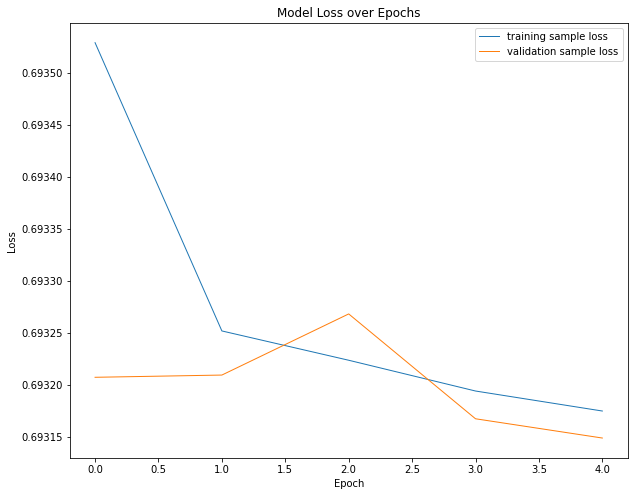

NameError: name 'ypred4c' is not defined

In [91]:
x_train,x_val,y_train,y_val = train_test_split(scaled_data[:,0:4],scaled_data[:,-1], test_size = 0.2, random_state=42) #rf label
#_,_,sby_train,sby_val = train_test_split(scaled_dataset[i][:,0:4],scaled_dataset[i][:,-2], test_size = 0.2, random_state=42) #SB label
x_test,sb_test = scaled_test_data[:,0:4],scaled_test_data[:,-1] #SB label
classifier = classifier_model()
history = classifier.fit(x_train, y_train, epochs=5, batch_size=128,validation_data=(x_val,y_val))
learningCurveLoss(history)
y_pred = classifier.predict(x_test)
ypred4c.append(y_pred)
fpr, tpr, thresholds = roc_curve(sb_test, y_pred)
auc_value = auc(fpr,tpr)
